In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # GPU ID

In [3]:
from exp.nb_databunch import *
from exp.fastai_imports import *
from exp.nb_AmishDataLoaders import *
from exp.amish_sites import *
from exp.resultsNplots import *
from exp.nb_spatiailMaxPooling import SpatialMaxPooling
from exp.nb_predict import *


from datetime import datetime


In [4]:
import seaborn as sns

sns.set_style('darkgrid',{'axes.spines.bottom': True,
             'axes.spines.left': True,
             'axes.spines.right': True,
             'axes.spines.top': True,
             'axes.edgecolor':'.0'})

sns.set_context('talk')
sns.set_palette('colorblind')

In [5]:
# Inputs (cdv, data_path, pathology) 

In [6]:
# amish_csv = "/opt/data/workingdir/nrakocz/oct/AMISH_SO_QC.csv"
amish_csv = "/opt/data/workingdir/nrakocz/oct/AMISH_12192019_wHypoDrusen.csv"

amish_df = pd.read_csv(amish_csv)
amish_df['CASE_ID_SHORT'] = amish_df.CASE_ID.apply(lambda x: x[:9])
# amish_df.set_index('CASE_ID',inplace=True)
amish_df = validateNumerical(amish_df)
amish_df = binarizeDataFrame(amish_df,cat_cols)

data_type='biomarkers'
df = amish_df


In [7]:
demog_df = pd.read_csv('/opt/data/workingdir/nrakocz/oct/demog.txt')
demog_df['CASE_ID'] = demog_df.ID.apply(lambda x: '_'.join([f'{int(i):04d}' for i in re.findall('\d+',x)]))
demog_df = demog_df.set_index('CASE_ID')
demog_df = demog_df.drop_duplicates()


df = pd.merge(left=amish_df,right=demog_df,how='left',left_on='CASE_ID_SHORT',right_on='CASE_ID').set_index('CASE_ID')
df = df.drop_duplicates(subset=['GROUP','INDIVIDUAL'])

age_m = df.Age[df.CENTER.isin(['UPEN','VAN'])].mean()
age_s = df.Age[df.CENTER.isin(['UPEN','VAN'])].std()

df['Gender_OD'] = df.Gender
df['Gender_OS'] = df.Gender
df['Age_OD'] = (df.Age - age_m)/age_s
df['Age_OS'] = (df.Age - age_m)/age_s
df = binarizeDataFrame(df,['Gender_OS','Gender_OD'])



In [8]:
df.head()

,STUDY,SUBSTUDY,CENTER,GROUP,INDIVIDUAL,EXAM_DATE,EXAMINER,EYE,CO_COMMENTS_OD,CO_COMMENTS_OS,...,CO_Drusen_Core_OS,Notes,CASE_ID_SHORT,ID,Gender,Age,Gender_OD,Gender_OS,Age_OD,Age_OS
CASE_ID,,,,,,,,,,,,,,,,,,,,,
0120_0005_08152013,AMD,AMDAMISH,UPEN,120,5,2013-08-15,Muneeswar,B,NaN,NaN,...,NaN,NaN,0120_0005,120─5,M,70.0,0.0,0.0,0.305597,0.305597
0120_0006_08152013,AMD,AMDAMISH,UPEN,120,6,2013-08-15,Muneeswar,B,NaN,NaN,...,0.0,NaN,0120_0006,120─6,F,68.0,1.0,1.0,0.127296,0.127296
0120_0007_08152013,AMD,AMDAMISH,UPEN,120,7,2013-08-15,Muneeswar,B,NaN,NaN,...,0.0,NaN,0120_0007,120─7,F,67.0,1.0,1.0,0.038146,0.038146
0120_0008_08152013,AMD,AMDAMISH,UPEN,120,8,2013-08-15,Muneeswar,B,NaN,NaN,...,0.0,NaN,0120_0008,120─8,F,65.0,1.0,1.0,-0.140155,-0.140155
0158_0010_08152013,AMD,AMDAMISH,UPEN,158,10,2013-08-15,Muneeswar,B,NaN,NaN,...,0.0,NaN,0158_0010,158─10,F,61.0,1.0,1.0,-0.496756,-0.496756


In [9]:
from exp.nb_predict import pathologies,covariants
pathologies, covariants

(['SO_SR_DRUSEN',
  'SO_HRF_IRHRFOND',
  'SO_HRF_HRFOD',
  'CO_RPE_V3MM_L0.03',
  'CO_Drusen_Core',
  'IRP_RP'],
 None)

In [10]:
df[[f'{p}_OD' for p in pathologies]]

,SO_SR_DRUSEN_OD,SO_HRF_IRHRFOND_OD,SO_HRF_HRFOD_OD,CO_RPE_V3MM_L0.03_OD,CO_Drusen_Core_OD,IRP_RP_OD
CASE_ID,,,,,,
0120_0005_08152013,0.0,0.0,0.0,0.0,NaN,0.0
0120_0006_08152013,0.0,0.0,0.0,0.0,0.0,0.0
0120_0007_08152013,0.0,0.0,0.0,0.0,0.0,0.0
0120_0008_08152013,0.0,0.0,0.0,0.0,0.0,0.0
0158_0010_08152013,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
4000_14118_01162017,0.0,0.0,0.0,0.0,0.0,0.0
4000_14192_12192016,0.0,0.0,0.0,0.0,0.0,0.0
4000_14206_12232016,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
single_task = (  (not (type(pathologies)==list)) | (len(pathologies)==1) )
single_task

False

In [12]:
isInAmishDf = partial(isInDf,df=df)
areValidpathologiesLabels = partial(areValidLabels,pathologies=pathologies,df=df)
isValidLabelPathology =  partial(isValidLabel,pathology=pathologies)
areValidCovLabels = partial(areValidLabels,pathologies=covariants,df=df)

In [13]:
data_path1 = miami_path/'Cube'
data_path2 = upen_path/'Cube'
data_path3 = ohio_cube_path

files_list= data_path1.l() + data_path3.l()
test_files_list = data_path2.l()

In [14]:
from skimage import io
f1 = files_list[50]
img0 = io.imread(f1)
h,w = img0.shape
print(h,w)

496 512


In [15]:
IMG_RSZ = (h//2,w//2)
CROP_SIZE = 224

In [16]:
# RUN

In [17]:
model_names = [
#     'Tile-Resnet',
#     'Tile-Resnet-Scratch',
#     'SLIVER-NET',
#     'SLIVER-scratch',
#     'ImageNet-SLIVER',
    '3D_CNN'
]

pretrained_model_names = ['SLIVER-NET','Tile-Resnet','ImageNet-SLIVER']

In [18]:
from exp.nb_predict import covModel,getArch

In [21]:
#=======================================
# INPUT
#=======================================


EPOCHS =  50
slices=97
BATCH = 16
do_tfms = False
rotation = (-5,5)
ncov = 0 if covariants is None else 2
MODEL_PATH = '/opt/data/workingdir/nrakocz/oct/models/kermany/resnet18/models/best.pth'
run_name = '3dcnn_vasMarkers_upenn'

criterion = torch.nn.BCEWithLogitsLoss() #<------ sigmoid
# criterion = torch.nn.BCELoss()
# criterion = torch.nn.CrossEntropyLoss() #<------ softmax
# criterion = LabelSmoothingCrossEntropy(eps=0.05)
# criterion = torch.nn.MSELoss()

#===========================================

## create learner 

p_list = '_'.join(pathologies)
model_dir  = f'models/{pathologies}_vol_{run_name}' if(type(pathologies) != list) else f'models/{p_list}_vol_{run_name}'
print('='*100,'OCT BIOMARKER DETECTION','Training the following models:',model_names,'Models dir:',model_dir,'='*100,sep='\n')
work_path = Path('/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final')
# RUN
print()
#===========================================


ds_params = {
    'df':df,
    'pathologies':pathologies,
    'n_workers':-1,
    'resize':(256,256),
    'rcrop_size':(224,224),
    'rotation':rotation,
    'do_transform':do_tfms,
    'unif_transform':True,
    'contrast':True,
    'hflip':True,
    'n_slices':slices, 
    'tiled':False,
    'classification':True,
    'data_type':data_type,
    'cov': covariants
    }


# %debug
ds = AmishVolumeDataset(files_list,**ds_params,mode='train')

ds = (ds.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)

     )

if(covariants is not None): ds=ds.filter_by_func(areValidCovLabels) 
print(len(ds))

### test set 

# %debug
ds_tst = AmishVolumeDataset(test_files_list,**ds_params,mode='test')

ds_tst = (ds_tst.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)
         )

if(covariants is not None): ds_tst=ds_tst.filter_by_func(areValidCovLabels) 
print(len(ds_tst))

### split data 

#### from ds

ds_tr, ds_val = ds.split_dataset(shuffle_dataset=True, pct=0.2,random_seed=42)

###  Data loaders

train_dl = torch.utils.data.DataLoader(ds_tr, batch_size=BATCH,num_workers=22)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=BATCH,num_workers=22)

a = next(iter(train_dl))

data = DataBunch(train_dl=train_dl, valid_dl=val_dl)
data.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1


#---------------------------------------
for model_name in model_names:
    print(model_name)
    LEARNER_ARCH = f'resnet18_{model_name}'

    learn = getArch(model_name,
            data=data,
            loss_func=criterion,
            path=work_path,
            model_dir=model_dir,
            multi_gpu=True,
            ds_params=ds_params)

    ## add callbacks 

    callbacks = []
    PATIENCE = 20
    callbacks.append(EarlyStoppingCallback(learn,patience=PATIENCE))
    callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=f'best_{LEARNER_ARCH}'))
    LEARNER_NAME = LEARNER_ARCH


    ## fit 

   
    learn.fit_one_cycle(EPOCHS,callbacks=callbacks)
    learn.load(f'best_{LEARNER_ARCH}')
    
    if(model_name in pretrained_model_names):
        learn.unfreeze()
        learn.fit_one_cycle(EPOCHS,callbacks=callbacks,max_lr=2e-6)
        learn.load(f'best_{LEARNER_ARCH}')
    
    learn.save(LEARNER_NAME)

    ### Infer

    tst_dl = torch.utils.data.DataLoader(ds_tst, batch_size=BATCH,num_workers=22, drop_last=False)
    data_tst = DataBunch(train_dl=train_dl, valid_dl=tst_dl)
    data_tst.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1

    learn_tst = Learner(data=data_tst, 
                    model = learn.model,
                    loss_func=criterion,
                    path=work_path,
                    model_dir=model_dir,)

    (y_pred,y_true),ci_dict, res_dict = print_ci(pathologies,learner=learn_tst,plot=False,use_softmax=single_task,iter=100)
    date_time = datetime.now().strftime("%m%d%y_%H%M")


    with open(f'{work_path/model_dir}/{LEARNER_NAME}_{slices}_slices_preds_{date_time}', "wb") as f:
        pickle.dump({'y_pred':y_pred,'y_true':y_true},f,pickle.HIGHEST_PROTOCOL)
        
    _ = learn.destroy()
    _ = learn_tst.destroy()
    import gc; gc.collect()
    torch.cuda.empty_cache()

Model	ROC	PR	ROC P-Value	PR P-Value
SO_SR_DRUSEN 	0.68[0.48,0.80] 	0.05[0.02,0.13] 	 	
SO_HRF_IRHRFOND 	0.63[0.53,0.74] 	0.12[0.05,0.27] 	 	
SO_HRF_HRFOD 	0.65[0.56,0.73] 	0.13[0.08,0.23] 	 	
CO_RPE_V3MM_L0.03 	0.71[0.55,0.83] 	0.12[0.05,0.25] 	 	
CO_Drusen_Core 	0.68[0.50,0.83] 	0.06[0.03,0.22] 	 	
IRP_RP 	0.78[0.66,0.85] 	0.10[0.04,0.22] 	 	
this Learner object self-destroyed - it still exists, but no longer usable
this Learner object self-destroyed - it still exists, but no longer usable


# Inference only

In [20]:
#=======================================
# INPUT
#=======================================


EPOCHS =  50
slices=97
BATCH = 16
do_tfms = False
rotation = (-5,5)
ncov = 0 if covariants is None else 2
MODEL_PATH = '/opt/data/workingdir/nrakocz/oct/models/kermany/resnet18/models/best.pth'
run_name = '3dcnn_vasMarkers_upenn'

criterion = torch.nn.BCEWithLogitsLoss() #<------ sigmoid
# criterion = torch.nn.BCELoss()
# criterion = torch.nn.CrossEntropyLoss() #<------ softmax
# criterion = LabelSmoothingCrossEntropy(eps=0.05)
# criterion = torch.nn.MSELoss()

#===========================================

## create learner 

p_list = '_'.join(pathologies)
model_dir  = f'models/{pathologies}_vol_{run_name}' if(type(pathologies) != list) else f'models/{p_list}_vol_{run_name}'
print('='*100,'OCT BIOMARKER DETECTION','Training the following models:',model_names,'Models dir:',model_dir,'='*100,sep='\n')
work_path = Path('/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final')
# RUN
print()
#===========================================


ds_params = {
    'df':df,
    'pathologies':pathologies,
    'n_workers':-1,
    'resize':(256,256),
    'rcrop_size':(224,224),
    'rotation':rotation,
    'do_transform':do_tfms,
    'unif_transform':True,
    'contrast':True,
    'hflip':True,
    'n_slices':slices, 
    'tiled':False,
    'classification':True,
    'data_type':data_type,
    'cov': covariants
    }


# %debug
ds = AmishVolumeDataset(files_list,**ds_params,mode='train')

ds = (ds.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)

     )

if(covariants is not None): ds=ds.filter_by_func(areValidCovLabels) 
print(len(ds))

### test set 

# %debug
ds_tst = AmishVolumeDataset(test_files_list,**ds_params,mode='test')

ds_tst = (ds_tst.filter_by_func(isInAmishDf)
        .filter_by_func(lambda f: 'Unknown' not in f.name)
        .filter_by_func(lambda f: 'ERROR' not in f.name)
        .filter_by_func(areValidpathologiesLabels)
         )

if(covariants is not None): ds_tst=ds_tst.filter_by_func(areValidCovLabels) 
print(len(ds_tst))

### split data 

#### from ds

ds_tr, ds_val = ds.split_dataset(shuffle_dataset=True, pct=0.2,random_seed=42)

###  Data loaders

train_dl = torch.utils.data.DataLoader(ds_tr, batch_size=BATCH,num_workers=22)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=BATCH,num_workers=22)

a = next(iter(train_dl))

data = DataBunch(train_dl=train_dl, valid_dl=val_dl)
data.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1


### Infer

tst_dl = torch.utils.data.DataLoader(ds_tst, batch_size=BATCH,num_workers=22, drop_last=False)
data_tst = DataBunch(train_dl=train_dl, valid_dl=tst_dl)
data_tst.c = len(pathologies) if isinstance(pathologies,list) else 2 if ds_params['classification'] else 1

    

OCT BIOMARKER DETECTION
Training the following models:
['3D_CNN']
Models dir:
models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_CO_RPE_V3MM_L0.03_CO_Drusen_Core_IRP_RP_vol_3dcnn_vasMarkers_upenn

/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5001_0101_10292013_OS_Cube_0.tiff : CO_Drusen_Core : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5001_9018_09032014_OD_Cube_0.tiff : SO_SR_DRUSEN : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0100_03312014_OD_Cube_0.tiff : IRP_RP : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0100_03312014_OS_Cube_0.tiff : IRP_RP : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0101_03052014_OD_Cube_0.tiff : CO_Drusen_Core : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_0101_03052014_OS_Cube_0.tiff : IRP_RP : nan
/opt/data/workingdir/nrakocz/oct/miami_imgs_e2e_par_full/Cube/5011_9003_03192014_OD_Cube_0.tiff : SO_SR_DRUSEN : nan


/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0914_0006_02132015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0914_0008_02132015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0914_0008_02132015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0926_0009_06112015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0927_0004_02262015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0927_0004_02262015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0946_0004_03102015_OD_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct/upen_imgs_e2e_par_full/Cube/0946_0004_03102015_OS_Cube_0.tiff : CO_RPE_V3MM_L0.03 : nan
/opt/data/workingdir/nrakocz/oct

In [21]:
#---------------------------------------
# for model_name in model_names:
model_name = model_names[0]
print(model_name)
LEARNER_ARCH = f'resnet18_{model_name}'

learn = getArch(model_name,
        data=data,
        loss_func=criterion,
        path=work_path,
        model_dir=model_dir,
        multi_gpu=True,
        ds_params=ds_params)

## add callbacks 

LEARNER_NAME = LEARNER_ARCH

## load
learn.load(f'best_{LEARNER_ARCH}')
learn_tst = Learner(data=data_tst, 
                model = learn.model,
                loss_func=criterion,
                path=work_path,
                model_dir=model_dir,)

learn_tst
# (y_pred,y_true),ci_dict, res_dict = print_ci(pathologies,learner=learn_tst,plot=False,use_softmax=single_task,iter=100)
# date_time = datetime.now().strftime("%m%d%y_%H%M")


# with open(f'{work_path/model_dir}/{LEARNER_NAME}_{slices}_slices_preds_{date_time}', "wb") as f:
#     pickle.dump({'y_pred':y_pred,'y_true':y_true},f,pickle.HIGHEST_PROTOCOL)

# _ = learn.destroy()
# _ = learn_tst.destroy()
# import gc; gc.collect()
# torch.cuda.empty_cache()

3D_CNN


In [52]:
preds = learn_tst.get_preds()
pd.DataFrame(preds[0].numpy(), 
             columns=pathologies, 
             index=[i[0].name for i in ds_tst.items]
            ).to_csv(os.path.join(learn_tst.path, f"{LEARNER_NAME}_preds.csv"))
pd.DataFrame(preds[1].numpy(), 
             columns=pathologies, 
             index=[i[0].name for i in ds_tst.items]
            ).to_csv(os.path.join(learn_tst.path, f"{LEARNER_NAME}_labels.csv"))

In [51]:
preds[1]

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [32]:
fnames = []

'resnet18_3D_CNN'

['0025_0007_10012015_OS_Cube_0.tiff',
 '0025_0011_07142014_OD_Cube_0.tiff',
 '0025_0011_07142014_OS_Cube_0.tiff',
 '0049_0005_05222014_OD_Cube_0.tiff',
 '0049_0005_05222014_OS_Cube_0.tiff',
 '0049_0006_01292015_OD_Cube_0.tiff',
 '0049_0006_01292015_OS_Cube_0.tiff',
 '0049_0008_03062014_OD_Cube_0.tiff',
 '0049_0008_03062014_OS_Cube_0.tiff',
 '0049_0010_03062014_OD_Cube_0.tiff',
 '0049_0010_03062014_OS_Cube_0.tiff',
 '0049_0011_03062014_OD_Cube_0.tiff',
 '0049_0011_03062014_OS_Cube_0.tiff',
 '0049_0012_06092016_OD_Cube_0.tiff',
 '0049_0012_06092016_OS_Cube_0.tiff',
 '0049_0014_05222014_OS_Cube_0.tiff',
 '0049_0015_01212016_OD_Cube_0.tiff',
 '0049_0015_01212016_OS_Cube_0.tiff',
 '0049_0019_06092016_OD_Cube_0.tiff',
 '0049_0019_06092016_OS_Cube_0.tiff',
 '0057_0005_06122014_OD_Cube_0.tiff',
 '0057_0005_06122014_OS_Cube_0.tiff',
 '0057_0012_11142013_OD_Cube_0.tiff',
 '0057_0012_11142013_OS_Cube_0.tiff',
 '0057_0013_11142013_OD_Cube_0.tiff',
 '0057_0013_11142013_OS_Cube_0.tiff',
 '0060_0010_

In [23]:
p_list = '_'.join(pathologies)
model_dir  = f'models/{pathologies}_vol' if(type(pathologies) != list) else f'models/{p_list}_vol_slices_upenn'

In [28]:
nadav_path = "/opt/data/workingdir/nrakocz/oct"
jeff_path = '/opt/data/workingdir/jnchiang/share/oct/3d_cnn_final'

preds_fl =[
     ('SLIVER-NET',f'{nadav_path}/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_SLIVER-NET_97_slices_preds_010320_0625'),
     ('Tile-Resnet',f'{nadav_path}/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_Tile-Resnet_97_slices_preds_010320_0222'),
     ('Tile-Resnet-Scratch',f'{nadav_path}/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_Tile-Resnet-Scratch_97_slices_preds_010320_0358'),
     ('SLIVER-scratch',f'{nadav_path}/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_SLIVER-scratch_97_slices_preds_010320_0724'),
     ('ImageNet-SLIVER',f'{nadav_path}/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_ImageNet-SLIVER_97_slices_preds_010320_1014'),
     ('3D_CNN',f'{jeff_path}/models/SO_SR_DRUSEN_SO_HRF_IRHRFOND_SO_HRF_HRFOD_SO_PED_DPED_vol_slices_upenn/resnet18_3D_CNN_97_slices_preds_010620_1150')
]

In [29]:
results = {p:{'y_pred':[],'y_true':[]} for p in pathologies}
preds_names = []

for n,f_path in preds_fl:
    preds_names.append(n)
    with open(f_path,'rb') as f:
        y_dict = pickle.load(f)
        for i,p in enumerate(pathologies):
            results[p]['y_pred'].append((y_dict['y_pred'][:,i]))
            results[p]['y_true'].append((y_dict['y_true'][:,i]))

SO_SR_DRUSEN
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.94[0.91,0.97] 	0.22[0.12,0.43] 	Baseline 	Baseline
Tile-Resnet 	0.91[0.84,0.97] 	0.25[0.11,0.47] 	0.92 	0.39
Tile-Resnet-Scratch 	0.75[0.57,0.91] 	0.14[0.05,0.33] 	0.998 	0.783
SLIVER-scratch 	0.86[0.77,0.93] 	0.14[0.06,0.35] 	0.992 	0.823
ImageNet-SLIVER 	0.81[0.73,0.90] 	0.09[0.04,0.21] 	1.0 	0.984
3D_CNN 	0.83[0.69,0.94] 	0.11[0.05,0.23] 	0.986 	0.935
SO_HRF_IRHRFOND
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.92[0.89,0.96] 	0.50[0.35,0.67] 	Baseline 	Baseline
Tile-Resnet 	0.94[0.90,0.97] 	0.52[0.37,0.70] 	0.217 	0.327
Tile-Resnet-Scratch 	0.92[0.86,0.96] 	0.44[0.32,0.62] 	0.578 	0.812
SLIVER-scratch 	0.88[0.82,0.93] 	0.42[0.28,0.59] 	0.981 	0.93
ImageNet-SLIVER 	0.91[0.86,0.96] 	0.40[0.27,0.58] 	0.788 	0.976
3D_CNN 	0.78[0.71,0.85] 	0.25[0.14,0.39] 	1.0 	1.0
SO_HRF_HRFOD
Model	ROC	PR	ROC P-Value	PR P-Value
SLIVER-NET 	0.91[0.85,0.95] 	0.42[0.31,0.58] 	Baseline 	Baseline
Tile-Resnet 	0.95[0.93,0.97] 	0.49[0.37,0.66

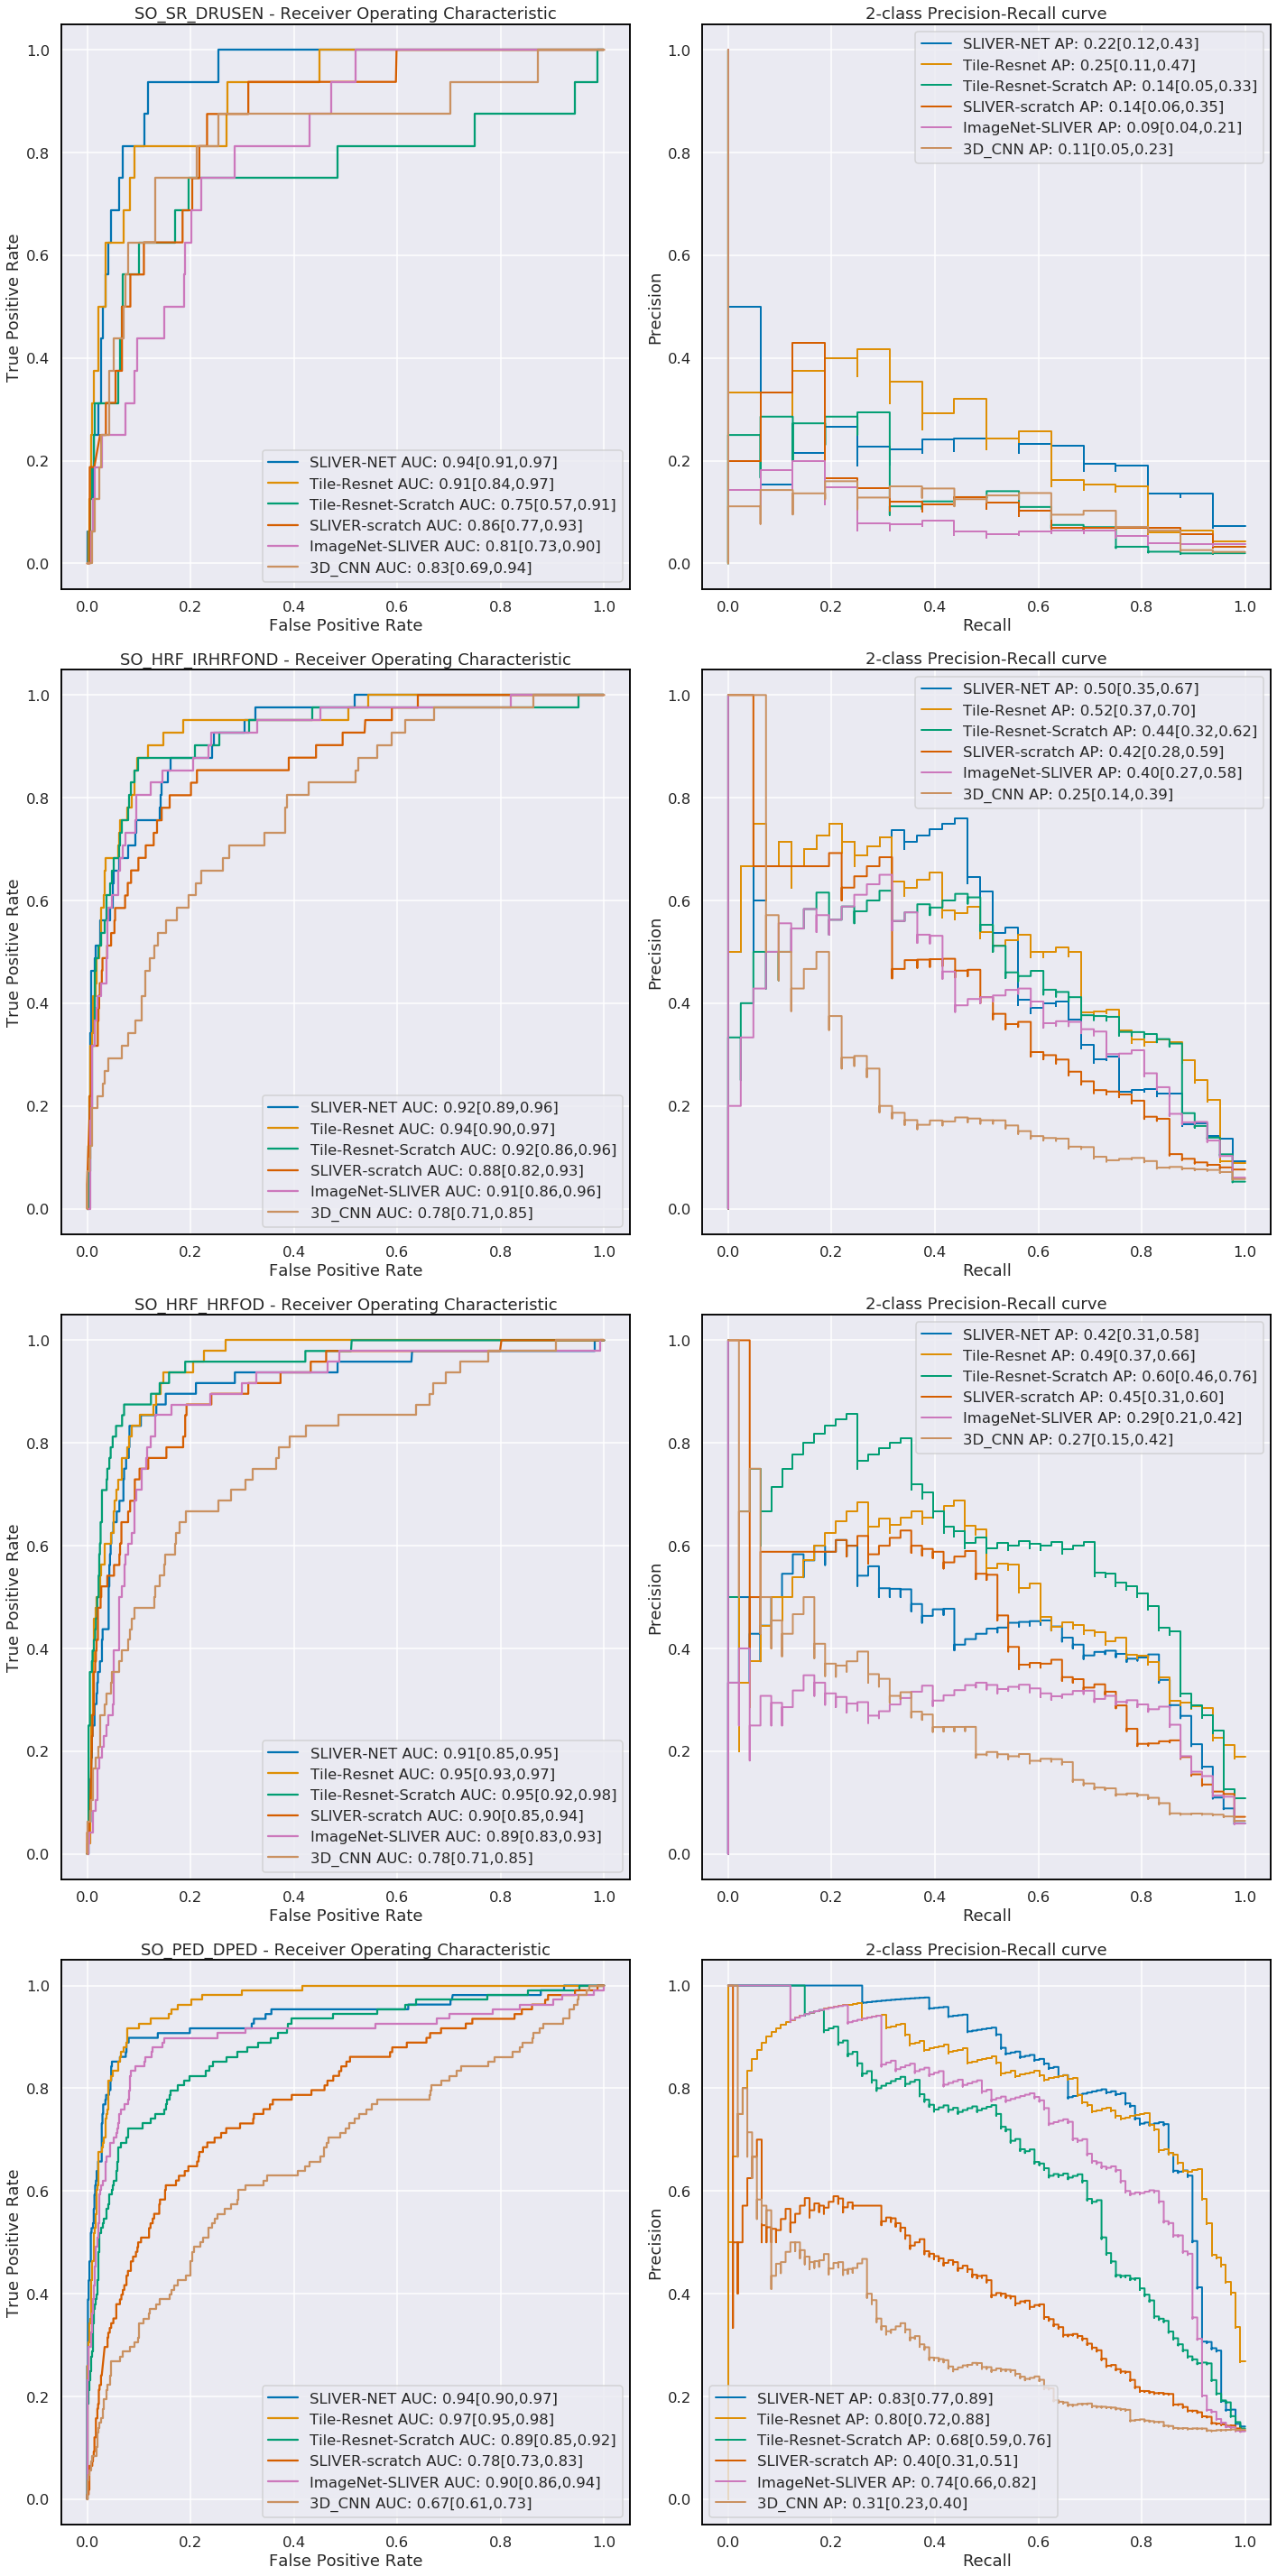

In [30]:
fig,axes = plt.subplots(len(pathologies),2,figsize=(20,10*len(pathologies)))
axes=axes.ravel()
ci_dicts = []

for i,p in enumerate(pathologies):
    y_pred = results[p]['y_pred']
    y_true = results[p]['y_true']

    print(p)
    _,ci_dict,res_dict = print_ci(preds_names,
                   y_pred=np.array(y_pred).T,y_true=np.array(y_true).T,plot=True,ax = axes[2*i],ax2=axes[2*i+1],
                   title = f'{p} - Receiver Operating Characteristic',t_test=True,iter=1000)
    
    
    ci_dicts.append(ci_dict)
    
fig.tight_layout()

In [ ]:
def ci2errs(vals,ci):
    return np.abs(np.array(ci).T - np.array(vals))